In [6]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [7]:
%matplotlib notebook

In [8]:
# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [9]:
pl.rcParams['axes.labelsize']

16.0

# Dataset info

In [10]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'


#### Get metadata for stimulus

In [11]:
experiment = 'blobs'

In [12]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [13]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) 
                              for session, animalid, fovnum in zip(sdata_exp['session'].values, 
                                                                   sdata_exp['animalid'].values,
                                                                   sdata_exp['fovnum'].values)]

sdata_exp[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,13,13,13
Lm,12,12,12
V1,11,11,11


#### Drop duplicates and whatnot fovs

In [19]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
filter_str = 'stim-filter-%s_%s' % (stim_filterby, g_str)

In [20]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [21]:

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly


# Output dir

In [22]:
#### Output dir
#stats_dir = os.path.join(aggregate_dir, 'data-stats')

responsive_dir = os.path.join(aggregate_dir, 'responsivity', 'compare_tests')
print(responsive_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity/compare_tests


# Select responsive tests

In [36]:
#### Responsive params
response_type = 'dff'

responsive_test1 = 'nstds' # 'nstds' #'ROC' #None
responsive_thr1 = 10.0 if responsive_test1=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test1=='ROC' else 2.5 #None
response_str1 = '%s-thr-%.2f_%s' % (responsive_test1, responsive_thr1, response_type) 


responsive_test2 = 'ROC' # 'nstds' #'ROC' #None
responsive_thr2 = 10.0 if responsive_test2=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test2=='ROC' else 2.5 #None
response_str2 = '%s-thr-%.2f_%s' % (responsive_test2, responsive_thr2, response_type) 


print("Test 1: %s" % response_str1)
print("Test 2: %s" % response_str2)

Test 1: nstds-thr-10.00_dff
Test 2: ROC-thr-0.05_dff


In [72]:
experiment = 'blobs'
(experiment, responsive_test1, responsive_thr1, response_type)


('blobs', 'nstds', 10.0, 'dff')

# Load gratings or blobs

In [73]:
stats_dir = os.path.join(aggregate_dir, 'data-stats')
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f_%s_stimulus.pkl' 
                                               % (experiment, responsive_test1, responsive_thr1, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl']

In [74]:
aggr_trialmeans_dfile1 = glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f_%s_stimulus.pkl' 
                                               % (experiment, responsive_test1, responsive_thr1, response_type)))[0]
print(aggr_trialmeans_dfile1)
with open(aggr_trialmeans_dfile1, 'rb') as f:
    MEANS1 = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [75]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f_%s_stimulus.pkl' 
                                               % (experiment, responsive_test2, responsive_thr2, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl']

In [84]:
aggr_trialmeans_dfile2 = glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s-thr-%.2f_%s_stimulus.pkl' 
                                               % (experiment, responsive_test2, responsive_thr2, response_type)))[0]
print(aggr_trialmeans_dfile2)
with open(aggr_trialmeans_dfile2, 'rb') as f:
    MEANS2 = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl


# Select stimuli

In [85]:
include_stimuli='all'

animalid = 'JC084'
session = '20190522'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

if experiment == 'blobs':
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
else:
    obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()

# curr_datakeys = [k for k in stim_datakeys if k not in excl]
curr_sdata = sdata_exp[sdata_exp['datakey'].isin(stim_datakeys)].copy()
print(len(curr_sdata['datakey'].unique()), len(stim_datakeys))

Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
(25, 25)


In [86]:
all_configs = ['config%03d' % i for i in np.arange(1, sdf.shape[0]+1)]
if experiment=='blobs':
    control_configs = ['config001', 'config002', 'config003', 'config004', 'config005']
elif experiment=='gratings':
    control_configs = sdf[sdf['size']>100].index.tolist()
    
if include_stimuli=='fullscreen':
    included_configs = [c for c in all_configs if c in control_configs]
elif include_stimuli=='image':
    included_configs = [c for c in all_configs if c not in control_configs]
elif include_stimuli=='all':
    included_configs = all_configs
else:
    print("UNKNOWN: %s" % include_stimuli)
print("Restricting stimuli to: %s (%i conditions)" % (include_stimuli, len(included_configs)))

Restricting stimuli to: all (50 conditions)


In [88]:
MEANS1[datakey].shape, MEANS2[datakey].shape

((1500, 183), (1500, 108))

# Counts

In [89]:
d_list=[]
i=0
for (visual_area, datakey), g in sdata_exp.groupby(['visual_area', 'datakey']):
    for curr_test, MEANS in zip(['nstds', 'ROC'], [MEANS1, MEANS2]):
        if datakey not in MEANS.keys():
            print("... %s, missing %s" % (curr_test, datakey))
            continue

        _df = MEANS[datakey].copy()
        #mean_ntrials = _df.groupby(['config']).count().mean().iloc[0]
        #curr_ncells = _df.shape[1]
        d_list.append(pd.DataFrame({'visual_area': visual_area, 
                                    'datakey': datakey, 
                                    'n_cells': _df.shape[1],
                                    'test': curr_test}, index=[i]))
        i+=1
    
cellcounts = pd.concat(d_list, axis=0)


In [90]:
_df.shape

(1675, 87)

In [91]:
cellcounts

,datakey,n_cells,test,visual_area
0,20190502_JC076_fov1,151,nstds,Li
1,20190502_JC076_fov1,62,ROC,Li
2,20190602_JC091_fov1,242,nstds,Li
3,20190602_JC091_fov1,165,ROC,Li
4,20190605_JC090_fov1,130,nstds,Li
5,20190605_JC090_fov1,143,ROC,Li
6,20190606_JC091_fov1,137,nstds,Li
7,20190606_JC091_fov1,85,ROC,Li
8,20190607_JC091_fov1,261,nstds,Li
9,20190607_JC091_fov1,135,ROC,Li


In [92]:
cellcounts['animalid'] = [s.split('_')[1] for s in cellcounts['datakey']]
cellcounts['session'] = [s.split('_')[0] for s in cellcounts['datakey']]
cellcounts['fovnum'] = [s.split('_')[2] for s in cellcounts['datakey']]

In [93]:
visual_areas = ['V1', 'Lm', 'Li']

<IPython.core.display.Javascript object>


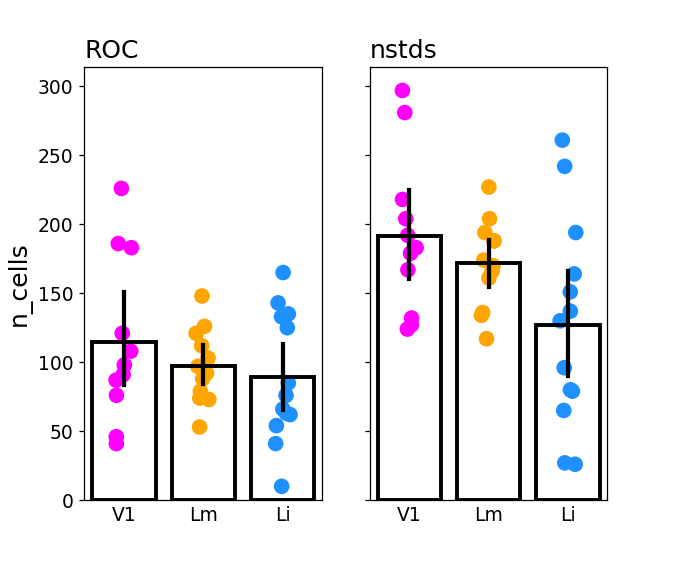

********* [ROC|n_cells] *********
[('V1', 'Lm')] p=0.532 (holm), reject H0=False
[('V1', 'Li')] p=0.487 (holm), reject H0=False
[('Lm', 'Li')] p=0.532 (holm), reject H0=False
********* [nstds|n_cells] *********
[('V1', 'Lm')] p=0.269 (holm), reject H0=False
[('V1', 'Li')] p=0.064 (holm), reject H0=False
[('Lm', 'Li')] p=0.073 (holm), reject H0=False


In [94]:
curr_metric='n_cells'
multi_comp_test ='holm'

fig, axn = pl.subplots(1, 2, figsize=(6,5), dpi=dpi, sharex=True, sharey=True)
fig.patch.set_alpha(0)
for ai, (ax, (experiment, expdf)) in enumerate(zip(axn.flat, cellcounts.groupby(['test']))):
    ax.patch.set_alpha(0)

    sns.barplot(x="visual_area", y=curr_metric, data=expdf, 
                ax=ax, order=visual_areas, ci=95,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
#     else:
#         sns.pointplot(x="visual_area", y=curr_metric, data=expdf, 
#                         ax=ax, order=visual_areas, ci=95,
#                         markers='_', join=False, capsize=0., dodge=True,
#                         scale=3, color='k')
    # Plot points
    #plotdf = mean_sizes if fov_means else expdf
    point_size = 10 #if fov_means else 5
    sns.stripplot(x='visual_area', y=curr_metric, data=expdf, 
                  zorder=-1, ax=ax, order=visual_areas, palette=area_colors,
                  s=point_size, color=(1,1,1,0), dodge=True, #facecolor=(1,1,1,0),
                  marker='o',linewidth=1, edgecolor='none')
    if ai>0:
        ax.set_ylabel('');
    ax.set_title(experiment, loc='left', fontsize=16)
    
    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(expdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.4), fontsize=8)
    ax.set_xlabel(''); ax.tick_params(axis='x', size=0);
    
    # Annotate w stats
    print("********* [%s|%s] *********" % (experiment, curr_metric))
    #_loc = 16 if fov_means else 23
    statresults = aggr.do_mannwhitney(expdf, metric=curr_metric, multi_comp_test=multi_comp_test)
    #aggr.annotate_stats_areas(statresults, ax, y_loc=y_loc, offset=1)

# ylim = 0 if fov_means else 0
# ax.set_ylim([ylim, ax.get_ylim()[-1]])
# pl.subplots_adjust(top=0.7, bottom=0.2, left=0.12, right=0.98)
# sns.despine(offset=4, trim=True, bottom=True)


In [104]:
sdata_exp[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,13
Lm,12
V1,11


<IPython.core.display.Javascript object>


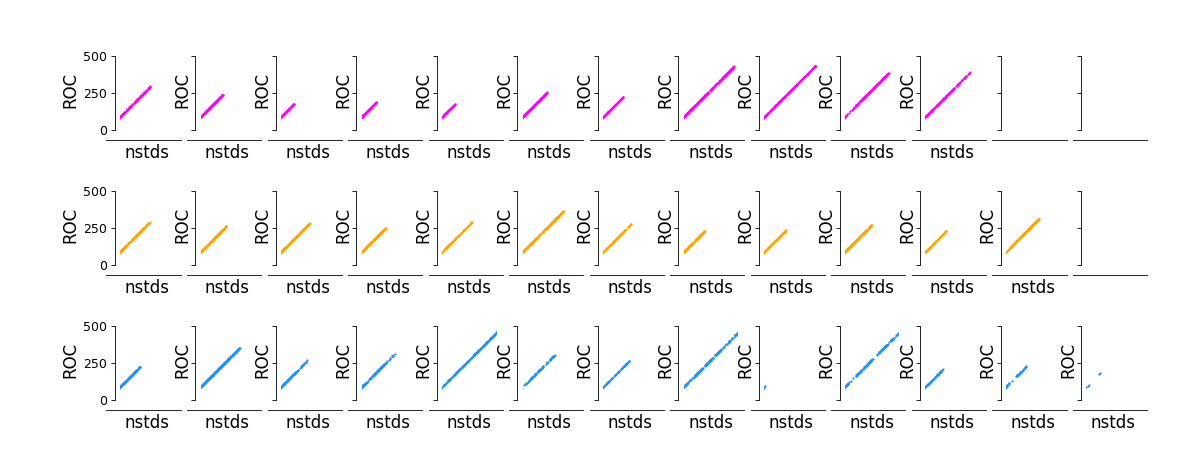

In [121]:
max_dkeys = 13
fig, axn = pl.subplots(3, max_dkeys,figsize=(16,6), sharex=True, sharey=True)

for visual_area, v_df in sdata_exp.groupby(['visual_area']):
    ri=visual_areas.index(visual_area)
    for di, (datakey, g) in enumerate(v_df.groupby(['datakey'])):
        ax = [ri, di]
        rlist1 = [r for r in MEANS1[datakey].columns if putils.isnumber(r)]
        rlist2 = [r for r in MEANS2[datakey].columns if putils.isnumber(r)]

        ax = axn[ri, di]

        all_rids = np.union1d(rlist1, rlist2)

        xvs = [i if i in rlist1 else -1 for i in all_rids]
        yvs = [i if i in rlist1 else -1 for i in all_rids]

        ax.scatter(xvs, yvs, c=area_colors[visual_area], marker='.', s=5)
        ax.set_xlabel(responsive_test1)
        ax.set_ylabel(responsive_test2)
        ax.set_aspect('equal')
pl.subplots_adjust(top=0.9, bottom=0.1, left=0.1, wspace=0.5, hspace=0.5, right=0.95)
sns.despine(trim=True, offset=5)


In [100]:
xvs

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 11,
 12,
 16,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 42,
 43,
 45,
 46,
 48,
 49,
 53,
 54,
 55,
 57,
 58,
 59,
 61,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 84,
 85,
 86,
 88,
 89,
 91,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 121,
 123,
 124,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 146,
 149,
 151,
 152,
 -1,
 156,
 162,
 164,
 166,
 167,
 168,
 169,
 -1,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 181,
 182,
 183,
 184,
 -1,
 188,
 191,
 192,
 193,
 194,
 195,
 -1,
 202,
 205,
 206,
 207,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 223,
 -1,
 225,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 237,
 239,
 240,
 242,
 -1,
 245,
 246,
 248,
 249,
 250,
 -1,
 253,
 254,
 -1,
 256,
 257,
 259,
 264,
 

# Signal correlations

In [389]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):

    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print('... missing %s' % datakey)
        continue
    trial_means = MEANS[datakey].copy() # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    tuning_ = trial_means[trial_means['config'].isin(included_configs)].groupby(['config']).mean().reset_index()
    cc = putils.melt_square_matrix(tuning_.corr(), metric_name='signal_cc', include_diagonal=False)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = aggr.add_meta_to_df(cc, metadict)
    x_list.append(cc)
signal_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_signal_corrs = signal_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

# Noise correlations

In [390]:
x_list = []
for (visual_area, animalid, session, fovnum), g in curr_sdata.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    if datakey not in MEANS.keys():
        print("[%s] skipping %s" % (visual_area, datakey))
        continue

    trial_means = MEANS[datakey] # shape: (ntrials_total, nrois_total)
    if response_type == 'corrected':
        cfg_tmp = trial_means['config']
        trial_means = putils.zscore_dataframe(trial_means)
        trial_means['config'] = cfg_tmp
    
    # mean-subtract
    rlist = [r for r in trial_means.columns if putils.isnumber(r)]
    tmeans = pd.concat([pd.concat([cdf[rlist] - cdf[rlist].mean(), cdf['config']], axis=1) \
                            for cfg, cdf in trial_means.groupby(['config'])]).reset_index(drop=True)

    # Calculate noise corr: ncorrs[(ncorrs['row']==0) & (ncorrs['col']==1)] # noise corrs, all conditions for neuron i, j (i=0, j=1)
    ncorrs = pd.concat([putils.melt_square_matrix(resp.corr(), metric_name='noise_cc', 
                                           add_values={'config': cfg}, include_diagonal=False) 
                        for cfg, resp in tmeans[tmeans['config'].isin(included_configs)].groupby(['config'])], axis=0)
    # Get mean noise corr over all stim conds for each pair
    cc = ncorrs.groupby(['row', 'col']).mean().reset_index()
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    cc = putils.add_meta_to_df(cc, metadict)
    x_list.append(cc)
noise_corrs = pd.concat(x_list, axis=0).reset_index(drop=True)

# Get mean across animals
mean_noise_corrs = noise_corrs.groupby(['visual_area', 'datakey']).mean().reset_index()

In [391]:
noise_corrs.shape, signal_corrs.shape

((376523, 8), (376523, 8))

In [380]:
noise_corrs.head()

,row,col,corrcoef,session,datakey,visual_area,fovnum,animalid
0,0,3,0.079753,20190502,20190502_JC076_fov1,Li,1,JC076
1,0,4,0.006020,20190502,20190502_JC076_fov1,Li,1,JC076
2,0,5,0.000222,20190502,20190502_JC076_fov1,Li,1,JC076
3,0,6,0.034200,20190502,20190502_JC076_fov1,Li,1,JC076
4,0,7,0.012852,20190502,20190502_JC076_fov1,Li,1,JC076


In [383]:
np.where(signal_corrs['row'] != noise_corrs['row'])


(array([], dtype=int64),)

In [394]:
corrs = signal_corrs.merge(noise_corrs)
print(corrs.shape)
corrs.head()


(376523, 9)


,row,col,signal_cc,session,datakey,visual_area,fovnum,animalid,noise_cc
0,0,3,0.797845,20190502,20190502_JC076_fov1,Li,1,JC076,0.079753
1,0,4,0.127072,20190502,20190502_JC076_fov1,Li,1,JC076,0.006020
2,0,5,0.132605,20190502,20190502_JC076_fov1,Li,1,JC076,0.000222
3,0,6,0.296826,20190502,20190502_JC076_fov1,Li,1,JC076,0.034200
4,0,7,0.000100,20190502,20190502_JC076_fov1,Li,1,JC076,0.012852


# Get screen and stimulus info

In [36]:
screeninfo = aggr.get_aggregate_stimulation_info(expdf)
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


NameError: name 'expdf' is not defined

# Load RF fits

In [41]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [55]:
from pipeline.python.rois.utils import load_roi_coords

In [395]:
reliable_only = True
#rfs_filter_by = None # Get all # match <EXP> datasets # 'drop_repeats'
rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)



#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


In [396]:
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)

matchblobs_reliable


# Get position info for RFs

In [ ]:
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

In [397]:
#if get_positions:
print("Calculating RF coord conversions...")
pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
for p in pos_params:
    rfdf[p] = ''
p_list=[]
for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
    fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                              traceid=traceid, create_new=False)

    for ei, e_df in g.groupby(['experiment']):
        cell_ids = e_df['cell'].unique()
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            rfdf[p][e_df.index] = p_[p].values
# with open(df_fpath, 'wb') as f:
#     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


# Select RFs

In [398]:
r_list=[]
for datakey, expdf in corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [399]:
RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


In [400]:
rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

,datakey
visual_area,
Li,9
Lm,8
V1,8


# Calculate overlap % bw cell pairs

In [401]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
n_dks = len(RFs['datakey'].unique())

o_list=[]
for di, ((visual_area, animalid, session, fovnum, datakey), g) in enumerate(RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey'])):
    if di%10==0:
        print("... %i of %i" % (int(di+1), n_dks))
        
    # convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    pair_ixs = list(itertools.combinations(np.arange(0, len(rf_polys)), 2))
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_polys[p1], rf_polys[p2]) for (p1, p2) in pair_ixs], axis=0)
    metadict={'visual_area': visual_area, 'animalid': animalid, 
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

... 1 of 25
... 11 of 25
... 21 of 25


# Add distance info between pairs

In [404]:
rf_datakeys = overlaps['datakey'].unique()
n_dks = len(rf_datakeys)

overlaps['distance'] = ''
x_list = []
for di, (datakey, overlap_) in enumerate(overlaps.groupby(['datakey'])):
    if di%5==0:
        print('%i of %i dsets' % (int(di+1), n_dks))
    # overlap_ = overlaps[overlaps['datakey']==datakey]

    rfs_ = RFs[RFs['datakey']==datakey].copy()
    rfs_.index=rfs_['cell'].values

    # Get cell ids common to EXP and RFs
    exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
    rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
    common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
    if len(common_rids) < 2:
        print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
    else:
        print("[%s] %i common cells" % (datakey, len(common_rids)))

    # Get signal corr values for current overlap pairs
    sig = corrs[corrs['datakey']==datakey].copy()
    i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
              for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
    sigs_with_rfs = pd.concat(i_list, axis=0)
    
    if len(sigs_with_rfs)==0:
        continue
        
    # Group by same pair ordering, and add the corresponding overlap_ entries
    overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
                         if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
    # Merge them
    merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    merger['distance'] = dists #d_df['distance'].values
    #print(merger.head())
    #print(merger.shape)
    
    x_list.append(merger)
roi_df = pd.concat(x_list, axis=0)


1 of 25 dsets
[20190420_JC076_fov1] 30 common cells
[20190430_JC078_fov1] 31 common cells
[20190502_JC076_fov1] 15 common cells
[20190504_JC078_fov1] 10 common cells
[20190506_JC080_fov1] 31 common cells
6 of 25 dsets
[20190507_JC083_fov1] 55 common cells
[20190508_JC083_fov1] 61 common cells
[20190512_JC083_fov1] 39 common cells
[20190522_JC084_fov1] 107 common cells
[20190525_JC084_fov1] 36 common cells
11 of 25 dsets
[20190602_JC091_fov1] 59 common cells
[20190605_JC090_fov1] 9 common cells
[20190606_JC091_fov1] 26 common cells
[20190609_JC099_fov1] 22 common cells
[20190613_JC097_fov1] 88 common cells
16 of 25 dsets
[20190616_JC097_fov1] 119 common cells
[20190617_JC097_fov1] 84 common cells
[20190617_JC099_fov1] 4 common cells
[20190618_JC097_fov1] 24 common cells
[20190622_JC085_fov1] 97 common cells
21 of 25 dsets
[20190627_JC091_fov1] 6 common cells
[20191006_JC110_fov1] 72 common cells
[20191018_JC113_fov1] 6 common cells
No pairs: 20191105_JC117_fov1 (exp has 79, rfs has 10)


In [405]:
roi_df.head()

,row,col,signal_cc,session,datakey,visual_area,fovnum,animalid,noise_cc,area_overlap,perc_overlap,distance
0,7,24,0.655716,20190420,20190420_JC076_fov1,V1,1,JC076,0.409519,1036.280440,0.907661,268.132066
1,7,25,0.138366,20190420,20190420_JC076_fov1,V1,1,JC076,0.261591,1260.666831,0.897161,312.988786
2,7,26,0.369180,20190420,20190420_JC076_fov1,V1,1,JC076,0.405807,1098.959686,0.782081,280.435363
3,7,32,0.234836,20190420,20190420_JC076_fov1,V1,1,JC076,0.379015,1134.460302,0.927412,458.066500
4,7,42,-0.323832,20190420,20190420_JC076_fov1,V1,1,JC076,0.080457,909.171355,0.966212,187.246909


In [327]:
# rf_datakeys = overlaps['datakey'].unique()
# n_dks = len(rf_datakeys)

# overlaps['distance'] = ''
# x_list = []
# for di, (datakey, overlap_) in enumerate(overlaps.groupby(['datakey'])):
#     if di%5==0:
#         print('%i of %i dsets' % (int(di+1), n_dks))
#     # overlap_ = overlaps[overlaps['datakey']==datakey]

#     rfs_ = RFs[RFs['datakey']==datakey].copy()
#     rfs_.index=rfs_['cell'].values

#     # Get cell ids common to EXP and RFs
#     exp_rids = sorted([r for r in MEANS[datakey].columns if putils.isnumber(r)])
#     rf_rids = sorted(np.union1d(overlap_['row'].unique(), overlap_['col'].unique()))
#     common_rids = sorted(np.intersect1d(exp_rids, rf_rids)) 
#     if len(common_rids) < 2:
#         print("No pairs: %s (exp has %i, rfs has %i)" % (datakey, len(exp_rids), len(rf_rids)))
#     else:
#         print("[%s] %i common cells" % (datakey, len(common_rids)))

#     # Get signal corr values for current overlap pairs
#     sig = corrs[corrs['datakey']==datakey].copy()
#     i_list = [sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))] \
#               for (r1, r2), gg in overlap_.groupby(['row', 'col'])]
#     sigs_with_rfs = pd.concat(i_list, axis=0)
    
#     if len(sigs_with_rfs)==0:
#         continue
        
#     # Group by same pair ordering, and add the corresponding overlap_ entries
#     overlap_and_sig = pd.concat([gg for (r1, r2), gg in overlap_.groupby(['row', 'col']) \
#                          if len(sig[((sig['row']==r1) & (sig['col']==r2)) | ((sig['col']==r1) & (sig['row']==r2))])>0])
#     # Merge them
#     merger = pd.merge(sigs_with_rfs, overlap_and_sig)    

#     # Coords of cell1 in pair, in order
#     coords1 = np.array(rfs_.loc[merger['row'].values][['ml_pos', 'ap_pos']])
#     # Coords of cell2 in pair 
#     coords2 = np.array(rfs_.loc[merger['col'].values][['ml_pos', 'ap_pos']])

#     # Get dists, in order of appearance
#     dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
#     merger['distance'] = dists #d_df['distance'].values
#     #print(merger.head())
#     #print(merger.shape)
    
#     x_list.append(merger)
# roi_df = pd.concat(x_list, axis=0)


1 of 25 dsets
[20190420_JC076_fov1] 30 common cells
(435, 11)
[20190430_JC078_fov1] 31 common cells
(465, 11)
[20190502_JC076_fov1] 15 common cells
(105, 11)
[20190504_JC078_fov1] 10 common cells
(45, 11)
[20190506_JC080_fov1] 31 common cells
(465, 11)
6 of 25 dsets
[20190507_JC083_fov1] 55 common cells
(1485, 11)
[20190508_JC083_fov1] 61 common cells
(1830, 11)
[20190512_JC083_fov1] 39 common cells
(741, 11)
[20190522_JC084_fov1] 107 common cells
(5671, 11)
[20190525_JC084_fov1] 36 common cells
(630, 11)
11 of 25 dsets
[20190602_JC091_fov1] 59 common cells
(1711, 11)
[20190605_JC090_fov1] 9 common cells
(36, 11)
[20190606_JC091_fov1] 26 common cells
(325, 11)
[20190609_JC099_fov1] 22 common cells
(231, 11)
[20190613_JC097_fov1] 88 common cells
(3828, 11)
16 of 25 dsets
[20190616_JC097_fov1] 119 common cells
(7021, 11)
[20190617_JC097_fov1] 84 common cells
(3486, 11)
[20190617_JC099_fov1] 4 common cells
(6, 11)
[20190618_JC097_fov1] 24 common cells
(276, 11)
[20190622_JC085_fov1] 97 co

ValueError: No objects to concatenate

# Plot

In [463]:
n_bins_dist = 15
n_bins_overlap = 8

use_quartile=True

bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    roi_df['binned_dist'] = pd.qcut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    roi_df['binned_dist'] = pd.cut(roi_df['distance'], n_bins_dist, labels=False)
    roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

#_, bin_sizes = pd.qcut(tuning_corrcoefs['distance'], n_bins, retbins=True)
#bin_edges = bin_sizes[0:-1]
params = ['perc_overlap', 'area_overlap', 'distance', 'binned_dist']
for p in params:
    roi_df[p] = roi_df[p].astype(float)

binning: eqpop15


In [464]:
filter_str

'stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05'

In [465]:
min_ncells=10

too_few_cells = [k for k, g in roi_df.groupby(['datakey']) \
                 if len(np.union1d(g['row'].unique(), g['col'].unique()))<=min_ncells]
plotdf = roi_df[~roi_df['datakey'].isin(too_few_cells)]


<IPython.core.display.Javascript object>


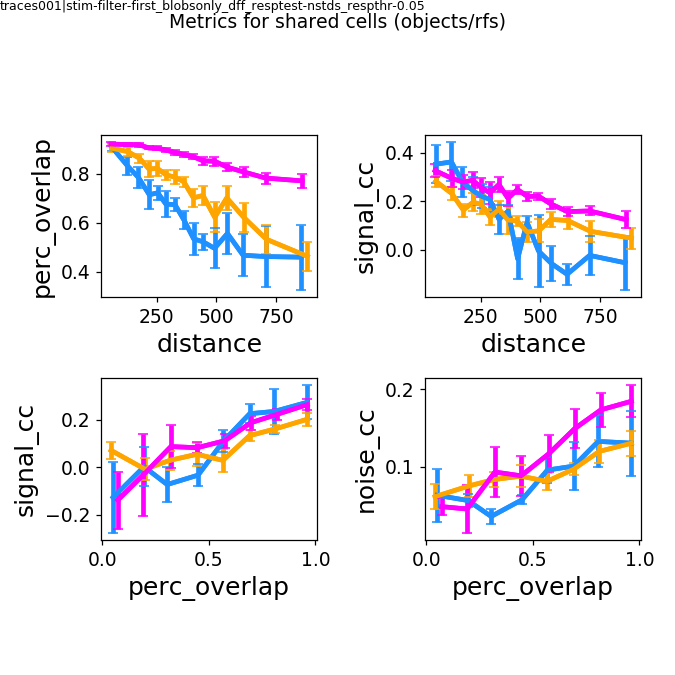

In [467]:
use_std = False

fig, axn = pl.subplots(2,2, figsize=(6,6), sharex=False, sharey=False, dpi=dpi)

ax = axn[0, 0]
x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[0, 1]
x_metric = 'binned_dist'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[1, 0]
x_metric = 'binned_overlap'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

ax = axn[1, 1]
x_metric = 'binned_overlap'
y_metric = 'noise_cc'
fig_title = 'Noise corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for visual_area, rdf in plotdf.groupby(['visual_area']):
    ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) 
    # Get binned x-axis values for labeling
    bin_dists = [b_df.groupby(['datakey'])[x_labeler].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # Get corresponding y-value averages
    bin_ccs = [b_df.groupby(['datakey'])[y_metric].mean().mean() for b, b_df in rdf.groupby([x_metric])]
    # .. and error bars
    bin_sems = [spstats.sem(b_df.groupby(['datakey'])[y_metric].mean()) for b, b_df in rdf.groupby([x_metric])]
    bin_stds = [b_df.groupby(['datakey'])[y_metric].mean().std() for b, b_df in rdf.groupby([x_metric])]
    bin_errs = bin_stds if use_std else bin_sems
    # Plot
    ax.plot(bin_dists, bin_ccs, color=area_colors[visual_area], 
           label='%s (%i)' % (visual_area, ncells_t), lw=3)
    ax.errorbar(bin_dists, bin_ccs, yerr=bin_errs, color=area_colors[visual_area], lw=3, capsize=3)
    ax.set_xlabel(x_labeler)
    ax.set_ylabel(y_metric)
#ax.set_title(fig_title, fontsize=12, loc='left')

fig.suptitle("Metrics for shared cells (objects/rfs)")
pl.subplots_adjust(top=0.8, bottom=0.2, wspace=0.5, hspace=0.5, left=0.15, right=0.95)
putils.label_figure(fig, data_id)

#figname = '%s_%s__%s_min%icells___%s' % (bin_type, min_ncells)

In [343]:
bin_ccs

[0.14251137775082801,
 0.21416458481146194,
 0.25517784195265875,
 0.28067622778481333,
 0.25086605055587713]

### Plot individual fovs

<IPython.core.display.Javascript object>


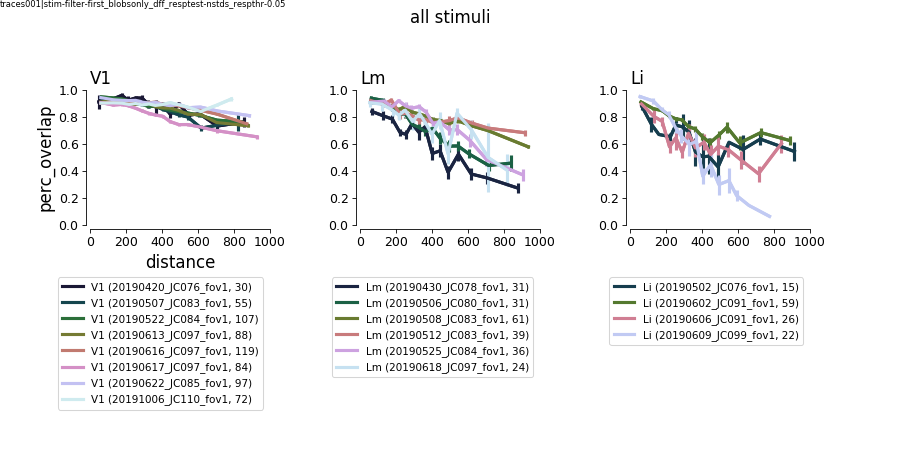

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'perc_overlap_by_binned_dist_split-fovs_eqpop15___stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05')


In [468]:

fig, axn = pl.subplots(1, 3, figsize=(12,6), sharex=False, sharey=False) #, dpi=dpi)

x_metric = 'binned_dist'
y_metric = 'perc_overlap'
fig_title = 'Perc. RF overlap by distance'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

for ax, (visual_area, rdf) in zip(axn.flat[::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):
        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.set_xticks(np.linspace(0, 1000, 6))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.legend(bbox_to_anchor=(0.99, -0.35)) #1))

axn[0].set_ylabel(y_metric)
axn[0].set_xlabel(x_labeler)

for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.3, bottom=0.5, top=0.8, left=0.1)

putils.label_figure(fig, data_id)
figname = '%s_by_%s_split-fovs_%s___%s' % (y_metric, x_metric, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)

In [444]:
correlations_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations'

<IPython.core.display.Javascript object>


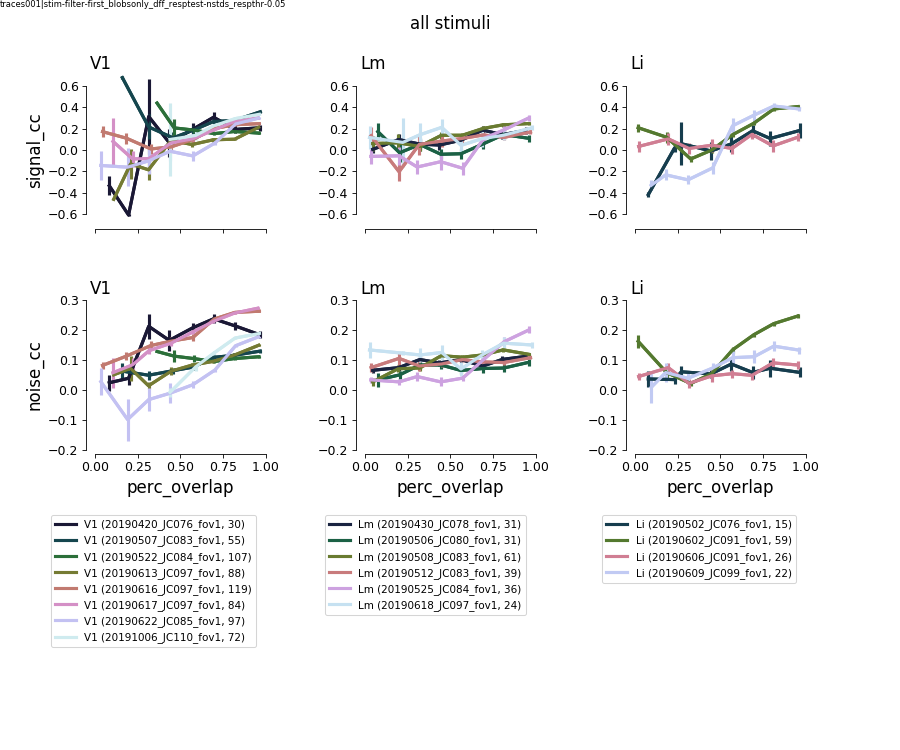

('/n/coxfs01/julianarhee/aggregate-visual-areas/correlations', 'corrcoefs_by_binned_overlap_split-fovs_eqpop15___stim-filter-first_blobsonly_dff_resptest-nstds_respthr-0.05')


In [478]:
fig, axn = pl.subplots(2, 3, figsize=(12,10), sharex=True, sharey=False) #, dpi=dpi)

x_metric = 'binned_overlap'
y_metric = 'signal_cc'
fig_title = 'Signal corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'
# Noise corrs
for ax, (visual_area, rdf) in zip(axn.flat[0:3][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):

        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    #ax.legend(bbox_to_anchor=(0.95, -0.3)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    ax.set_ylim([-0.7, 0.7])
    #ax.set_xticks(np.linspace(0, 1000, 6))
axn[0,0].set_ylabel(y_metric)
#axn[0,0].set_xlabel(x_labeler)


x_metric = 'binned_overlap'
y_metric = 'noise_cc'
fig_title = 'Noise corr. by RF overlap'
x_labeler = 'distance' if x_metric == 'binned_dist' else 'perc_overlap'

# Noise corrs
for ax, (visual_area, rdf) in zip(axn.flat[3:6][::-1], plotdf.groupby(['visual_area'])):
    dcolors = sns.color_palette('cubehelix', n_colors=len(rdf['datakey'].unique()))
    for dcolor, (dkey, g) in zip(dcolors, rdf.groupby(['datakey'])):

        ncells_t = len(np.union1d(g['row'].unique(), g['col'].unique())) #len(g['row'].unique())]) # for dk, g in currdf.groupby(['datakey'])])
        bin_dists = [b_df[x_labeler].mean() for b, b_df in g.groupby([x_metric])]  
        bin_ccs = [b_df[y_metric].mean() for b, b_df in g.groupby([x_metric])]
        bin_sems = [spstats.sem(b_df[y_metric]) for b, b_df in g.groupby([x_metric])]    
        # plot
        ax.plot(bin_dists, bin_ccs, color=dcolor, 
               label='%s (%s, %i)' % (visual_area, dkey, ncells_t), lw=3)
        ax.errorbar(bin_dists, bin_ccs, yerr=bin_sems, color=dcolor, lw=3)
    ax.set_ylabel('')
    ax.legend(bbox_to_anchor=(0.95, -0.4)) #1))
    ax.set_title(visual_area, loc='left', fontsize=16)
    #ax.set_xticks(np.linspace(0, 1000, 6))
    ax.set_ylim([-0.2, 0.3])
axn[1,0].set_ylabel(y_metric)
for ai in np.arange(0, 3):
    axn[1,ai].set_xlabel(x_labeler)


for ax in axn.flat:
    sns.despine(trim=True, offset=4, ax=ax)

pl.suptitle('%s stimuli' % include_stimuli, fontsize=16)
pl.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.4, top=0.9, left=0.1)

putils.label_figure(fig, data_id)
figname = 'corrcoefs_by_%s_split-fovs_%s___%s' % (x_metric, bin_type, filter_str)
pl.savefig(os.path.join(correlations_dir, '%s.svg' % figname))
print(correlations_dir, figname)


In [485]:
curr_datakeys = plotdf['datakey'].unique()
curr_rfdf = RFs[RFs['datakey'].isin(curr_datakeys)]
screeninfo = aggr.get_aggregate_stimulation_info(curr_rfdf)

Creating session object [JC076|20190502|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
[JC076|20190502] not found: gratings
Stimuli presented at coords: (-5, 8)
Creating session object [JC091|20190602|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating gratings object [JC091|20190602|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
Creating session object [JC091|20190606|FOV1_zoom2p0x]
... found 1 anatomical runs.
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_blobs_static
Creating gratings object [JC091|20190606|FOV1_zoom2p0x|traces001]
... getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
Creati

In [486]:
visual_areas = ['V1', 'Lm', 'Li']

In [487]:
screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())


<IPython.core.display.Javascript object>


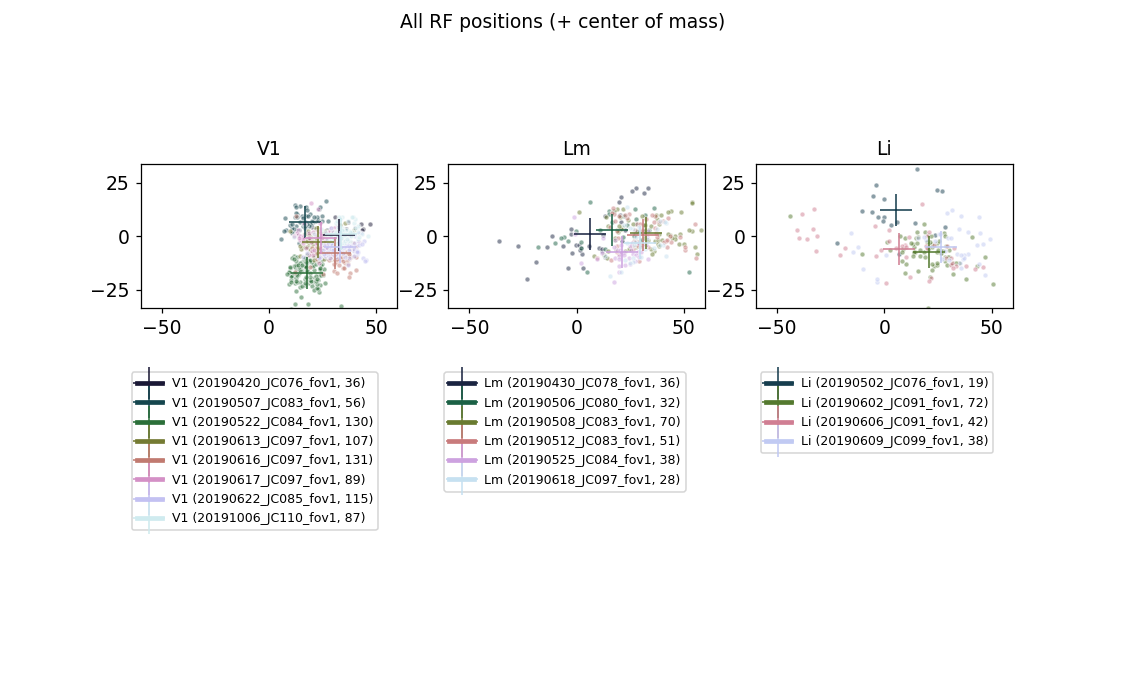

In [488]:

fig, axn = pl.subplots(1,3, figsize=(10,6), dpi=dpi)
for visual_area, v_df in curr_rfdf.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    dcolors = sns.color_palette('cubehelix', n_colors=len(v_df['datakey'].unique()))
    for di, (datakey, d_df) in enumerate(v_df.groupby(['datakey'])):
        sns.scatterplot('x0', 'y0', data=d_df, ax=ax, color=dcolors[di],
                        #palette=dcolors, #area_colors[visual_area],
                       s=10, marker='o', alpha=0.5) #, edgecolor='k') #area_colors[visual_area])

        x = d_df['x0'].values
        y=d_df['y0'].values
        
        ncells_t = d_df.shape[0]
        m=np.ones(d_df['x0'].shape)
        cgx = np.sum(x*m)/np.sum(m)
        cgy = np.sum(y*m)/np.sum(m)
        #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
        ax.plot(cgx, cgy, marker='+', markersize=20, color=dcolors[di], #area_colors[visual_area],
                label='%s (%s, %i)' % (visual_area, datakey, ncells_t), lw=3)
        
    ax.set_title(visual_area)
    ax.legend(bbox_to_anchor=(0.95, -0.4), fontsize=8) #1))

for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("All RF positions (+ center of mass)")
pl.subplots_adjust(top=0.9, bottom=0.4)


# label_figure(fig, data_id)
# figname = 'all_rfs_with_CoM_label-fovs__%s_%s' % (rfname, thr_str)
# pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
# print(genstats_dir, figname)

In [489]:
MEANS.keys()

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1',
 '20190422_JC076_fov1',
 '20191111_JC120_fov1',
 '20190517_JC083_fov1',
 '20190613_JC097_fov1',
 '20191018_JC113_fov1',
 '20190622_JC085_fov1',
 '20190501_JC076_fov1',
 '20191008_JC091_fov1',
 '20190504_JC078_fov1',
 '20190606_JC091_fov1',
 '20190605_JC090_fov1',
 '20191105_JC117_fov1',
 '20190618_JC097_fov1',
 '20190602_JC091_fov1',
 '20190507_JC083_fov1',
 '20190614_JC091_fov1',
 '20190616_JC097_fov1',
 '20190508_JC083_fov1',
 '20190612_JC099_fov1',
 '20190609_JC099_fov1',
 '20190617_JC097_fov1',
 '20190511_JC083_fov1',
 '20190509_JC078_fov1',
 '20190430_JC078_fov1',
 '20191006_JC110_fov1',
 '20190525_JC084_fov1',
 '20190607_JC091_fov1',
 '20190522_JC084_fov1',
 '20190617_JC099_fov1',
 '20190627_JC091_fov1',
 '20190513_JC078_fov1',
 '20190502_JC076_fov1']

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)

